### Evolution of Stellar Kinematics in M33

In this notebook, I am answering the question: how will the velocity dispersion of M33 evolve during the M31-MW merger?

I will plot the evolution of the velociy dispersion over time.

In [14]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G
import astropy.table as tbl

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from Readfile import Read
from CenterOfMass import CenterOfMass

In [15]:
# make a class
class V_disp:
    # Class to compute the velocity and velocity dispersion of an input galaxy
    
    def __init__(self, galaxy, snap_id, ptype=2):
        
        """
        inputs: 
            galaxy: the name of the galaxy, input as string
            snap_id: the timestamp at which velocity is computed,
                     can be input as int or array of int
            ptype: the particle type whose velocity is computed
                    default: 2
                    1 for halo, 2 for stars, 3 for bulge
        """
        
            
        if snap_id < 9.9:
               self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_00" + str(snap_id) + ".txt"
        elif snap_id < 99.9:
               self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_0" + str(snap_id) + ".txt"
        elif snap_id > 99.9:
              self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_" + str(snap_id) + ".txt"
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        #create an array to store indexes of particles of desired Ptype                                
        self.index = np.where(self.data['type'] == ptype)

        # store the mass, positions, velocities of only the particles of the given type
        # the following only gives the example of storing the mass
        self.m = self.data['m'][self.index]
        # write your own code to complete this for positions and velocities
        self.m = self.data["m"][self.index]
        self.x = self.data["x"][self.index]
        self.y = self.data["y"][self.index]
        self.z = self.data["z"][self.index]
        self.vx = self.data["vx"][self.index]
        self.vy = self.data["vy"][self.index]
        self.vz = self.data["vz"][self.index]
        
        
    def ReltoCoM(self):
        """
        function computes position and velocity of particles relative to their center of mass
        inputs: none, accepts inputs from __init__
        returns: 
            vtot: the total magnitude of the velocity vector
            vD: the 3-vector velocity
            rD: the 3-vector position
        """
        
        # Create instance of CenterOfMass of oobject
        COMD = CenterOfMass(self.filename,2)
        
        # Compute COM position and velocity using disk particles
        COMP = COMD.COM_P(0.1,4)
        COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
        
        # Determine positions of particles relative to COM 
        xD = COMD.x - COMP[0] 
        yD = COMD.y - COMP[1]
        zD = COMD.z - COMP[2] 
        # 3-vector position 
        rD = np.array([xD, yD, zD])
        # total magnitude of the position vector
        rtot = np.sqrt(xD**2 + yD**2 + zD**2)

        # Determine velocities of particles relative to COM motion
        vxD = COMD.vx - COMV[0]
        vyD = COMD.vy - COMV[1]
        vzD = COMD.vz - COMV[2]
        
        # 3-vector velocity
        vD = np.array([vxD, vyD, vzD])
        # total magnitude of velocity vector
        self.vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
        
        return self.vtot, vD, rD

                    
    def velocity_dispersion(self, velocity):
        """
        function computes the velocity dispersion of particles
        inputs: velocity: the velocities whose dispersion you are computing
        returns: the velocity dispersion, the average velocity, and the ratio of velocity to dispersion
        """
        # compute average velocity
        avg_v = np.sum(velocity)/(len(velocity))
        
        # create array of zeros
        v_disp = np.zeros_like(velocity)
        
        # compute (velocity dispersion)**2
        for i in range(len(velocity)):
            v_disp[i] = (velocity[i]-avg_v)**2
        v_disp = np.sqrt(np.sum(v_disp)/len(v_disp))
        
        v_ratio = np.divide(avg_v, v_disp)
        
        # return average velocity and velocity dispersion
        return avg_v, v_disp, v_ratio
    

In [16]:
# as per Dr. Besla's reccomendation, a rotation


# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction
    
    # transpose the inputs
    posI = posI.T
    velI = velI.T
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel


In [17]:
M33_VDispersion = V_disp("M33",0)
M33_vtot, M33_vD, M33_rD = M33_VDispersion.ReltoCoM()
# I need to find the dimensions of the velocity arrays
print(M33_vD.shape)
M33_rotP, M33_rotV = RotateFrame(M33_rD, M33_vD)
print(M33_rotV.T.shape)

(3, 9300)
(3, 9300)


In [42]:

# set up zeros arrays
snap_ids = np.arange(0,800,5)

# arrays for the distances and velocities relative to CoM
M33_vD = np.zeros((len(snap_ids),3, 9300))
M33_rD = np.zeros_like(M33_vD)

# arrays for the 3-D Dispersion, Average, and Ratio
M33_vDisp  = np.zeros((len(snap_ids),3))
M33_vAvg   = np.zeros_like(M33_vDisp)
M33_vRatio = np.zeros_like(M33_vDisp)

# arrays for the total velocities
M33_vtot        = np.zeros((len(snap_ids), 9300))
M33_RotatedTotV = np.zeros_like(M33_vtot)

# arrays for the total Average, Dispersion, and ratio
M33_TotAvg    = np.zeros(len(snap_ids))
M33_TotDisp   = np.zeros_like(M33_TotAvg)
M33_TotRatio  = np.zeros_like(M33_TotAvg)


In [43]:
# compute mean velocity and velocity dispersion along a given axis:
for i in range(len(snap_ids)):
    n = snap_ids[i]
    # create instance of class
    M33_VDispersion = V_disp("M33",n)
    
    M33_vtot[i,:], M33_vD[i,:,:], M33_rD[i,:,:] = M33_VDispersion.ReltoCoM()
    
    # rotate such that angular momentum is along z axis
    M33_rotatedP, M33_rotatedV = RotateFrame(M33_rD[i,:,:], M33_vD[i,:,:])
   
    # calculate total v
    M33_RotatedTotV[i,:] = np.sqrt((M33_rotatedV[:,0]**2 + M33_rotatedV[:,1]**2 + M33_rotatedV[:,0]**2))
    # compute total average velocity, v dispersion, and v/sigma
    M33_TotAvg[i], M33_TotDisp[i], M33_TotRatio[i] = M33_VDispersion.velocity_dispersion(M33_RotatedTotV[i])

    # compute dimensional average, dispersion, v/sigma ratio
    for j in range(3):
        
        M33_vAvg[i,j], M33_vDisp[i,j], M33_vRatio[i,j] = M33_VDispersion.velocity_dispersion(M33_rotatedV[:,j])
    
   


In [44]:
# compute V/Sigma for total velocity, total velocity dispersion



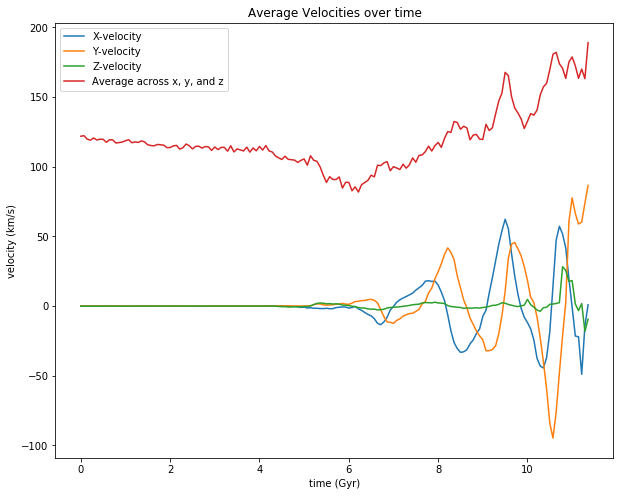

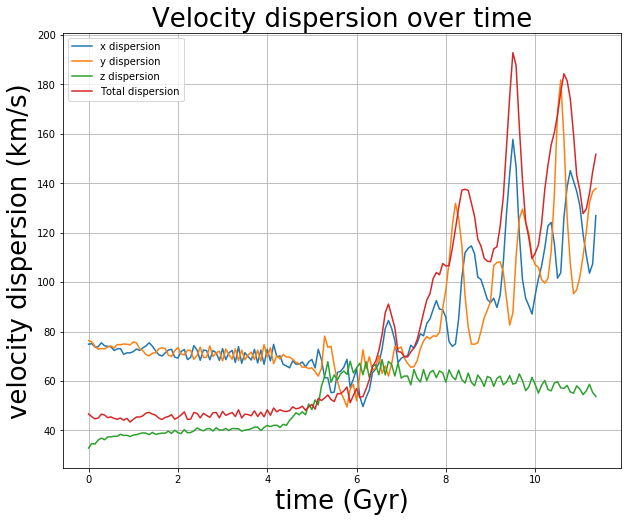

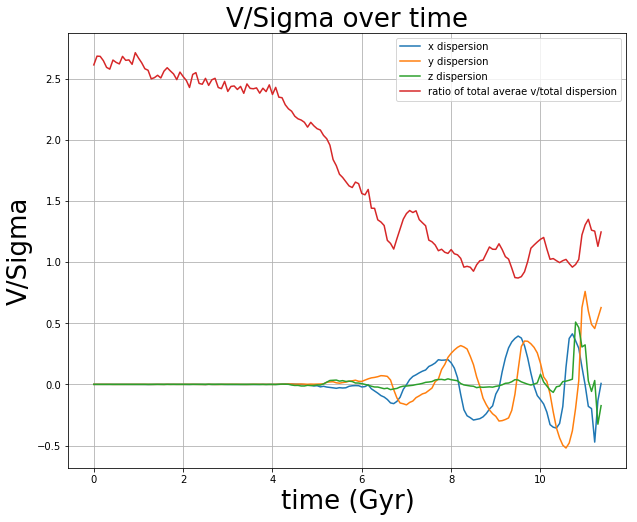

In [45]:
# read in from Orbit_M33.txt from assignment 6 to get the time
M33t, M33x, M33y, M33z, M33vx, M33vy, M33vz = np.genfromtxt("Orbit_M33.txt",delimiter=" ", unpack = True)
t = M33t[0:len(snap_ids)]/10e2
# plot the mean of the different velocity dimensions
plt.figure(figsize=(10,8))
plt.title("Average Velocities over time")
plt.xlabel("time (Gyr)")
plt.ylabel("velocity (km/s)")
plt.plot(t,M33_vAvg[:,0], label="X-velocity")
plt.plot(t, M33_vAvg[:,1], label="Y-velocity")
plt.plot(t, M33_vAvg[:,2], label="Z-velocity")
plt.plot(t, M33_TotAvg, label="Average across x, y, and z")
plt.legend()
plt.show()

# plot the velocity dispersion over time
plt.figure(figsize=(10,8))
plt.title("Velocity dispersion over time",fontsize=26,)
plt.ylabel("velocity dispersion (km/s)",fontsize=26)
plt.xlabel("time (Gyr)",fontsize=26)
plt.plot(t,M33_vDisp[:,0], label="x dispersion")
plt.plot(t,M33_vDisp[:,1], label="y dispersion")
plt.plot(t,M33_vDisp[:,2], label="z dispersion")
plt.plot(t,M33_TotDisp, label="Total dispersion")
plt.legend()
plt.grid()
plt.show()

# plot the velocity/sigma ratio over time
plt.figure(figsize=(10,8))
plt.title("V/Sigma over time",fontsize=26,)
plt.ylabel("V/Sigma",fontsize=26)
plt.xlabel("time (Gyr)",fontsize=26)
plt.plot(t,M33_vRatio[:,0], label="x dispersion")
plt.plot(t,M33_vRatio[:,1], label="y dispersion")
plt.plot(t,M33_vRatio[:,2], label="z dispersion")
plt.plot(t,M33_TotRatio, label="ratio of total averae v/total dispersion")
#plt.plot(t, M33_vRatio[])
plt.legend()
plt.grid()
plt.show()



Assuming I did this correctly (which is assuming a lot), M33 becomes a kind of oblate spheroid elliptical

In [ ]:
# need to compare peak mean velocity to velocity dispersion at that point
# that will give me info on the ellipticity of the galaxy
# compare to lecture 15

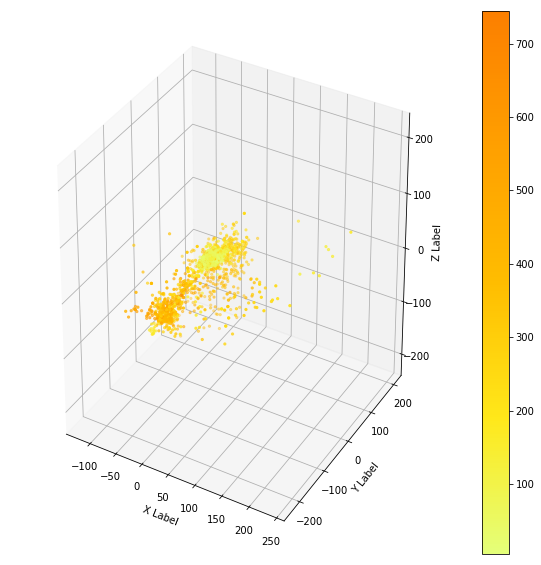